Detecting Malaria in Blood Cells using Convolutional Neutal Network

In [171]:
# Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import time

import matplotlib.pyplot as plt
%matplotlib inline

# Verify tensorflow installation
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.0.0


In [93]:
# Load image files
DATADIR = "C:/Users/gabriel.l.santiago/cell_images"
CATEGORIES = ["Parasitized", "Uninfected"]

In [94]:
# Resize images
IMG_SIZE = 70

# Create training dataset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
    
create_training_data()
print(len(training_data))

27558


In [95]:
# Randomize training data
random.shuffle(training_data)

for sample in training_data[:10]:
    print(sample[1])

1
0
1
0
1
0
0
1
0
0


In [96]:
# Prepare data for modeling
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [97]:
# Save data
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [98]:
# Normalize data
X = X/255.0

In [99]:
# Number of features
layer_size = 64

# Setup model
model = Sequential()

# Initial conv layer
model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(layer_size, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

# Flatten layers from 2D to 1D
model.add(Flatten())

# Dense layer
model.add(Dense(layer_size))
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 68, 68, 64)        640       
_________________________________________________________________
activation_12 (Activation)   (None, 68, 68, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)       

In [100]:
# Add tensorboard as keras callback
MODEL_NAME = "MalariaDetection-20Epochs-With2Dropout-ProperSave"
NAME = MODEL_NAME + "-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir="logs\{}".format(NAME))

In [101]:
# Train model
# cmd: tensorboard --logdir logs
BATCH_SIZE = 32
EPOCHS = 20
VALIDATION_SPLIT = 0.3 

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, callbacks=[tensorboard])

Train on 19290 samples, validate on 8268 samples
Epoch 1/20
19290/19290 [==============================] - 101s 5ms/sample - loss: 0.6417 - accuracy: 0.6164 - val_loss: 0.4743 - val_accuracy: 0.8047
Epoch 2/20
19290/19290 [==============================] - 117s 6ms/sample - loss: 0.2820 - accuracy: 0.8974 - val_loss: 0.1913 - val_accuracy: 0.9346
Epoch 3/20
19290/19290 [==============================] - 113s 6ms/sample - loss: 0.1862 - accuracy: 0.9383 - val_loss: 0.1628 - val_accuracy: 0.9434
Epoch 4/20
19290/19290 [==============================] - 106s 6ms/sample - loss: 0.1664 - accuracy: 0.9431 - val_loss: 0.1604 - val_accuracy: 0.9429
Epoch 5/20
19290/19290 [==============================] - 103s 5ms/sample - loss: 0.1562 - accuracy: 0.9480 - val_loss: 0.1744 - val_accuracy: 0.9425
Epoch 6/20
19290/19290 [==============================] - 107s 6ms/sample - loss: 0.1461 - accuracy: 0.9514 - val_loss: 0.1559 - val_accuracy: 0.9448
Epoch 7/20
19290/19290 [===========================

In [141]:
# Save model
model.save(MODEL_NAME + ".model")

INFO:tensorflow:Assets written to: MalariaDetection-20Epochs-With2Dropout-ProperSave.model\assets


In [63]:
# Use models on images
def prepare(filepath):
    IMG_SIZE = 70
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    new_array = np.array(new_array).astype(np.float32)
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [142]:
# Filename of model to be loaded
# FILE_NAME = "MalariaDetection" # 20 epochs
FILE_NAME = MODEL_NAME + ".model" # 6 epochs

# Load model
model_loaded = tf.keras.models.load_model(FILE_NAME)

print(FILE_NAME, " has been loaded.")

MalariaDetection-20Epochs-With2Dropout-ProperSave.model  has been loaded.


[[1.]]
Uninfected


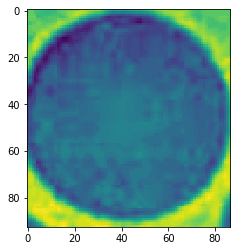

In [184]:
# Make prediction
filename = 'cellimages_test/Uninfected/healthy5.png'
image = prepare(filename)
plt.imshow(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

prediction = model_loaded.predict([image])
# prediction = model.predict([image])
print(prediction)
print(CATEGORIES[int(prediction[0][0])])

In [177]:
# visualize CNN layers
from keras.models import Model

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model_loaded.input, outputs=layer_outputs)
activations = activation_model.predict(image)

def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5, col_size*1.5))
    
    for row in range(0, row_size):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

TypeError: object of type 'InputLayer' has no len()